Anthony Isensee

To give credit where credit is due, the stragies demonstrated by this project are derived from the book *Hands-On Machine Learning with Scikit-Learn, Keras, & TensorFlow*, a machine learning guide by Aurélien Géron. I highly recommend this textbook as an incredible resource for the individual wishing to utilize the incredible strength of machine learning.

# The Goal - Predicting Medical Insurance Costs

Using the dataset from https://www.kaggle.com/mirichoi0218/insurance/home our goal is to use machine learning to predict the medical insurance costs incurred by unique individuals based on feature labels defining information gathered about the individuals.

We utilize the following strategy to achieve this goal:

1. Get the data.
2. Explore the data.
3. Prepare the data.
4. Select, train, and evaluate a model using the data.

# 0. Basic Imports and Setup


In [ ]:
# Support Python2 and Python3 functions
from __future__ import division, print_function, unicode_literals

# Numpy for number processing.
import numpy as np

# Set a 'random' seed for consistent results across platforms.
np.random.seed(42)

# 1. Get the Data

Here, we download a copy of the data to our local environment.

In [ ]:
## Load Insurance Dataset to File ##

# Operating system utilities, especially for directory creation and file storage.
import os

# Import library for data retrieval from URL.
from six.moves import urllib

# URL for Data File
# See https://www.kaggle.com/mirichoi0218/insurance/home for original source of dataset.
DATSET_DOWNLOAD_URL = "https://raw.githubusercontent.com/rlsummerscales/CPTR435/master/data/insurance.csv"

# Local path at which to store data.
INSURANCE_DATASET_PATH = os.path.join("datasets", "insurance")

## Gather data from URL ##
def fetch_insurance_data(insurance_url=DATSET_DOWNLOAD_URL, insurance_path=INSURANCE_DATASET_PATH):
    
    # Create a directory on the current OS to store the data in.
    if not os.path.isdir(insurance_path):
        os.makedirs(insurance_path)

    # Build a local path for the data file
    csv_path = os.path.join(insurance_path, "insurance.csv")

    # Download the dataset
    urllib.request.urlretrieve(insurance_url, csv_path)

# Fetch the dataset and load into local directory
fetch_insurance_data()

We then take that data and load it into a pandas dataframe.

In [ ]:
## Load Dataset .csv into Pandas Dataframe ##

# Import pandas so we can actually use it's dataframe object
import pandas as pd

# Takes a file, loads it into a pandas dataframe, and returns that dataframe. 
def load_insurance_data(insurance_path=INSURANCE_DATASET_PATH):
    csv_path = os.path.join(insurance_path, "insurance.csv")
    return pd.read_csv(csv_path)

# Load data into dataframe
insurance = load_insurance_data()

# 2. Explore the data

We now find out more about our data. We do the following to get a taste of the data:

# Display the first few rows for sampling:

In [ ]:
# Display the first few rows for sampling.
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# Display the value counts for sex, smoker, and region. 

Essentially, these are the values present in the dataset, as well as how many of that value are present in each set.

In [ ]:
# Display value counts for sex
insurance["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [ ]:
# Display value counts for smoker
insurance["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [ ]:
# Display value counts for region
insurance["region"].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

# Histograms of Numerical Features

We then plot histograms for easy visual depictions of each feature. 

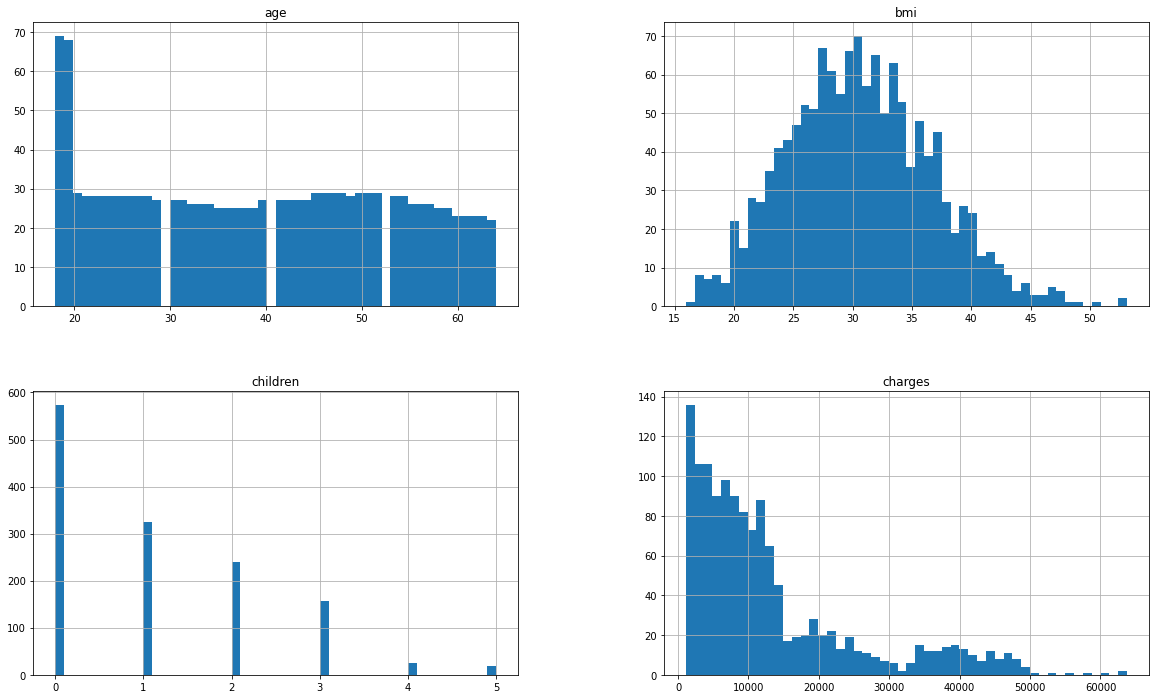

In [ ]:
# Show plots inline
%matplotlib inline

# Import matplotlib's pyplot features
import matplotlib.pyplot as plt

# Uses matplotlib.pyplot.hist to plot histograms
insurance.hist(bins=50, figsize=(20,12))

# Shows plots
plt.show()

# Histogram & Data Observations

In viewing the histograms, we make several observations:


1.   The majority of individuals have 0 children. The next majority have 1, then 2, etc.
2.   Data is limited to 5 child households.
3.   The vast majority of charges lie between \$0 and \$15,000 dollars. (Assuming charges are in dollars.)
4.   There is a very even distribution of age, *except for individuals younger than 20*.
5.   Several values of age appear to have no data points (29, 41, and 53). Additionally, the cutoff for age data seems to be 65. This could limit our predictive capability for anyone who is those specific ages or older than 65.
5.   Most individuals have a BMI of around 30%.



# Stratified Split

Now, we perform a stratified split of the dataset, using the smoker attribute as the primary feature we wish to split evenly. 

Note that we are only splitting once (we are not performing K-fold cross validation) and that our test set size will be 20%, meaning our training set size will naturally be the remaining 80%.

In [ ]:
# Import scikitlearn's stratified shuffle split.
from sklearn.model_selection import StratifiedShuffleSplit

# We set up the desired parameters for our split.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=51)

# Spilt object is a generator. Need for loop to make it generate a split.
# split(x, label) -> splits array x between train and test making sure that
# each label (e.g. each income category) is equally represented in both train and test sets.
# The probability distribution of the labels should be roughly the same in both sets.

# We use a for loop to equally distribute items in the training and test sets.
for train_index, test_index in split.split(insurance, insurance["smoker"]):
    print('Training samples: {}, testing samples: {}'
          .format(train_index.shape, test_index.shape))
    
    stratified_training_set = insurance.loc[train_index]
    stratified_testing_set = insurance.loc[test_index]

Training samples: (1070,), testing samples: (268,)


# Verification of Stratified Split

Now, we verify that the stratified split actually performed the split with roughly the same percentage of smokers in the training set as the test set. We divide each category (as we saw before, the answers no/yes) by the number of total items in the set to see the decimal percentage of each feature.

In [ ]:
# Decimal percentage of each feature in training set
stratified_training_set["smoker"].value_counts() / len(stratified_training_set)

no     0.795327
yes    0.204673
Name: smoker, dtype: float64

In [ ]:
# Decimal percentage of each feature in test set
stratified_testing_set["smoker"].value_counts() / len(stratified_testing_set)

no     0.794776
yes    0.205224
Name: smoker, dtype: float64

Awesome! It's a very even distribution between test and training sets, at least based on this one feature. 

# Comparison to Random Split

Out of curiosity, let's see what a randomized split might give us based on this sole feature!

In [ ]:
# Import the simple, randomized train_test_split function
from sklearn.model_selection import train_test_split

# Create a random split
example_training_set, example_testing_set = train_test_split(insurance, test_size=0.2, random_state=12)

In [ ]:
# Decimal percentage of each feature in example training set
example_training_set["smoker"].value_counts() / len(example_training_set)

no     0.790654
yes    0.209346
Name: smoker, dtype: float64

In [ ]:
# Decimal percentage of each feature in example training set
example_testing_set["smoker"].value_counts() / len(example_testing_set)

no     0.813433
yes    0.186567
Name: smoker, dtype: float64

Definitely not as good, demonstrating how nice it can be to be able to perform a stratified split to have even distribution over your training and testing sets of a feature with particular importance!
.

# Identify Correlations w/ Correlation Matrix

Now, we wish to identify important correlations. One of the ways we can easily do this is with a correlation matrix, which shows us which values correspond to which other values the most often.

In [ ]:
# Create a correlation matrix
insurance_correlation_matrix = insurance.corr()

# Print results
insurance_correlation_matrix

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


# Correlation Observations

Looking at this correlation matrix, we see the highest correlations (other than between features and themselves) occur between age and charges. We are very interested in the charges category, so we use further code to isolate and order by significance. This doesn't simplify too much since there are currently so few numerical categories, but it does help us to see which categories might have the largest influence on costs.

In [ ]:
insurance_correlation_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

As we can see, it runs age, bmi, and then finally children (children having comparitively little correlation).

# 3. Prepare the data

Now, we want to actually start processing our data so that we can train a machine learning model with it.

# Remove Desired Output Labels

We begin by copying the output labels (the charges category) from the datasets. Then, we remove the labels from the main dataset.

In [ ]:
# Copy out labels from sets
stratified_training_set_labels = stratified_training_set["charges"].copy()
stratified_testing_set_labels = stratified_testing_set["charges"].copy()

# Drop output labels from both sets
stratified_training_set = stratified_training_set.drop("charges", axis=1)
stratified_testing_set = stratified_testing_set.drop("charges", axis=1)

# Check for Missing Attribute Values

Now, we check for missing attribute values. As we can see, there are none, which makes our lives significantly easier. Yay for complete datasets!

If there were incomplete rows, we could use scikitlearn's Imputer class to fix missing values in a data set using a specific strategy. (Or, if we're feeling lazy, we could drop the rows with missing features. If we're feeling *really* lazy we could even drop the feature.)

In [ ]:
incomplete_rows = insurance[insurance.isnull().any(axis=1)].head()
incomplete_rows

,age,sex,bmi,children,smoker,region,charges


# One Hot Encode Categorical Features

Unfortunately, looking at our data as a whole, see that only four of our features are numerical data. We'd like to be able to convert the rest of the features to numerical data so that we can easily feed the dataset to a Machine Learning algorithm. So, we make changes to the data.

We note that we will need to process 3 features: sex, smoker, and region. Thankfully (and I found this out the hard way) we can do them all at once.

While we could use label encoding to assign a certain number to each unique label, this could imply some sort of numeric scale to be associated with the labels. Since we do not desire this, we use a one-hot encoding approach. To do this, we create an array with the same number of spaces as we have number of labels for each feature. Then, we set solely the indexed position in the array associated with that label to 1, leaving all other values at 0.

In [ ]:
# Import OneHotEncoder to perform one-hot encoding
from sklearn.preprocessing import OneHotEncoder

# Create the encoder
category_encoder = OneHotEncoder()

# Set the category
insurance_category_to_encode = insurance[["sex", "smoker", "region"]]

# Perform the encoding
insurance_only_categorical_features = category_encoder.fit_transform(insurance_category_to_encode)

# Convert from default sparse array to normal array and print
insurance_only_categorical_features.toarray()

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

# Housekeeping

Additionally, now that we've encoded the categorical features and stored just those in their own array, we want to remove them from the original dataset so that we can isolate only the numerical features.

In [ ]:
insurance_only_numerical_features = insurance.drop('sex', axis=1)
insurance_only_numerical_features = insurance_only_numerical_features.drop('smoker', axis=1)
insurance_only_numerical_features = insurance_only_numerical_features.drop('region', axis=1)
insurance_only_numerical_features = insurance_only_numerical_features.drop('charges', axis=1)

# Create a Full Pipeline

Now, we must create a class to select numerical and categorical features from our dataset. This will be essential to the pipeline we are about to set up.

In [ ]:
# Import for DataFrameSelector class to function
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

First, we import the pipeline class so that we may utilize its functionality.


In [ ]:
# Import the pipeline class from scikitlearn
from sklearn.pipeline import Pipeline

Now, we create a pipeline for numerical and categorical functions, then join those two pipelines together to create one beautiful pipeline.

Numerical features pipeline:

In [ ]:
## Numerical Features Pipeline ##

# Define numerical attributes to select with our numerical pipeline.
# These are the features labels only present in the ridiculously 
# long variable insurance_only_numerical_features. 
numerical_attributes = list(insurance_only_numerical_features)

# Create a pipeline for preparing numerical features
numerical_pipeline = Pipeline([
    ('selector', DataFrameSelector(numerical_attributes)),
  ])

Categorical features pipeline:

In [ ]:
## Categorical Features Pipeline ##

# Define categorical attributes to select with our categorical pipeline
category_attributes = ["sex", "smoker", "region"]

# Create a pipeline for preparing categorical features
categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_attributes)),
    ('category_encoder', OneHotEncoder(sparse=False))
  ])

Combined pipeline:

In [ ]:
## Combine Both Pipelines ##

# Import scikitlearn's FeatureUnion to combine pipelines
from sklearn.pipeline import FeatureUnion

full_pipeline = FeatureUnion(transformer_list=[
    ("numerical_pipeline", numerical_pipeline),
    ("categorical_pipeline", categorical_pipeline),
  ])

And finally, we run a quick check on our data to make sure our pipeline is working. All we see is numbers, so we appear to be golden!

In [ ]:
insurance_prepared = full_pipeline.fit_transform(insurance)
insurance_prepared

array([[19.  , 27.9 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [18.  , 33.77,  1.  , ...,  0.  ,  1.  ,  0.  ],
       [28.  , 33.  ,  3.  , ...,  0.  ,  1.  ,  0.  ],
       ...,
       [18.  , 36.85,  0.  , ...,  0.  ,  1.  ,  0.  ],
       [21.  , 25.8 ,  0.  , ...,  0.  ,  0.  ,  1.  ],
       [61.  , 29.07,  0.  , ...,  1.  ,  0.  ,  0.  ]])

# 4. Select, train, and evaluate a model

Finally! The fun part. Now, we can use our data pipelinet to prepare any dataset, and feed the resulting dataset to any machine learning model.

In this case, we will compare performance between three different machine learning algorithms:

1. Linear Regression
2. Decision Tree Regression
3. Random Forest Regression.

For all three models, we will eventually use 10-fold cross-validation to ensure the most accurate results. That said, we begin *without* Cross-Validation to make sure the models are working correctly.



# Prepare Data

We start by using our pipeline to clean and process both our training and testing sets. We ammend "ready" to the end of the variable name to indicate the data's final status. We also re-label the variables caryrying our output labels so that they match the format of the data.

In [ ]:
# Run insurance dataset through full pipeline.
# We note that we are using the stratified training/testing sets, 
# or stratified_training_set and stratified_testing_set
train_insurance_data_ready = full_pipeline.fit_transform(stratified_training_set)
test_insurance_data_ready = full_pipeline.fit_transform(stratified_testing_set)

# Re-label variables carrying output labels (the charges category)
train_insurance_labels = stratified_training_set_labels
test_insurance_labels = stratified_testing_set_labels

# Print information about our data
# Note that data is (number_of_instances, number_of_labels)
print("Training set: {}".format(train_insurance_data_ready.shape))
print("Test set: {}".format(test_insurance_data_ready.shape))

Training set: (1070, 11)
Test set: (268, 11)


# Train Basic Models

We begin by training a linear regression model with our training data. We'll soon use 10-fold cross-validation with identical models as well, but for now we want to establish a baseline metric with a single version of the model.

In [ ]:
# Import for Linear Regression model
from sklearn.linear_model import LinearRegression

# Create the model
linear_regression_model = LinearRegression()

# Train the model
linear_regression_model.fit(train_insurance_data_ready, train_insurance_labels)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Of course, just training the model doesn't do much for us. We'd now like to use that model to make predictions about other data, here our test set. We will use Root Mean Squared error as our metric.

In [ ]:
# Import mean_squared_error
from sklearn.metrics import mean_squared_error

# Using our model, predict values for each sample in the testing set
insurance_cost_predictions = linear_regression_model.predict(train_insurance_data_ready)

# Create RMSE of linear regression model on training data
linear_regression_mse = mean_squared_error(train_insurance_labels, insurance_cost_predictions)
linear_regression_rmse = np.sqrt(linear_regression_mse)

# Print results
print("RMSE of Linear Regression Model: {}".format(linear_regression_rmse))

RMSE of Linear Regression Model: 5880.664402701746


Now, we train a basic Decision Tree Regression model with the same data and calculate its RMSE.

In [ ]:
# Import DecisionTreeRegressor from scikitlearn
from sklearn.tree import DecisionTreeRegressor

# Create the model
decision_tree_regression_model = DecisionTreeRegressor(random_state=21)

# Train the model
decision_tree_regression_model.fit(train_insurance_data_ready, train_insurance_labels)

# Using our model, predict values for each sample in the testing set
decision_tree_insurance_cost_predictions = decision_tree_regression_model.predict(train_insurance_data_ready)

# Create RMSE of model on training data
decision_tree_mse = mean_squared_error(train_insurance_labels, decision_tree_insurance_cost_predictions)
decision_tree_rmse = np.sqrt(decision_tree_mse)

# Print results
print("RMSE of Decision Tree Regression Model: {}".format(decision_tree_rmse))

RMSE of Decision Tree Regression Model: 270.2373612509658


We see that the RMSE of decision Tree Regression is significantly lower. Decision trees are much better at memorizing the training set, however, so we won't really know just how good this specific model is until we ask it to predict our test set.

That said, another way we can test it is to implement many decision trees with a Random Forest Regressor, which uses a number of slightly different trees to come up with the final result. So, we train a basic Random Forest Regressor model to do just that.

In [ ]:
# Import RandomForestRegressor model from scikitlearn
from sklearn.ensemble import RandomForestRegressor

# Create the model. Note that we are creating 10 separate decision trees.
random_forest_regression_model = RandomForestRegressor(random_state=21, n_estimators=10)

# Train the model
random_forest_regression_model.fit(train_insurance_data_ready, train_insurance_labels)

# Using our model, predict values for each sample in the testing set
random_forest_insurance_cost_predictions = random_forest_regression_model.predict(train_insurance_data_ready)

# Create RMSE of model on training data
random_forest_regression_mse = mean_squared_error(train_insurance_labels, random_forest_insurance_cost_predictions)
random_forest_regression_rmse = np.sqrt(random_forest_regression_mse)

# Print results
print("RMSE of Random Forst Regression Model: {}".format(random_forest_regression_rmse))

RMSE of Random Forst Regression Model: 2059.2719778674386


Awesome! It looks like creating a 'committee' of trees causes our model to perform significantly less overfitting.

# K-Fold Cross-Validation

Finally, now that we've established each individual model, we run each with 10-fold cross-validation, just to see how well each model holds up when trained with slightly different data sets.

In [ ]:
## Linear Regression ##

# Import for cross-validation
from sklearn.model_selection import cross_val_score

# Run 10-fold cross-validation with linear regression model.
linear_regression_10f_cv_scores = cross_val_score(
    linear_regression_model, train_insurance_data_ready, 
    stratified_training_set_labels, scoring="neg_mean_squared_error", 
    cv=10)

# Calculate RMSE of scores
linear_regression_rmse_scores = np.sqrt(-linear_regression_10f_cv_scores)

# Print a list of RMSE values
print("Results of 10-f c-v for Linear Regression:")
print(linear_regression_rmse_scores)

# Load scores into panda DataFrame to quickly calculate stats
print("Measurements on results:")
print(pd.Series(linear_regression_rmse_scores).describe())

Results of 10-f c-v for Linear Regression:
[5367.44838036 6624.94109849 6536.01561369 6134.72010058 5911.99635761
 5546.25088899 5551.72707151 6711.70655398 5653.46146106 5170.37965706]
Measurements on results:
count      10.000000
mean     5920.864718
std       554.073586
min      5170.379657
25%      5547.619935
50%      5782.728909
75%      6435.691735
max      6711.706554
dtype: float64


Interestingly, we note that the average RMSE is actually less accurate than the basic linear regression model that did not have 10-fold cross-validation.

In [ ]:
## Decision Tree Regression ##

# Run 10-fold cross-validation with a decision tree regression model.
decision_tree_regression_10f_cv_scores = cross_val_score(
    decision_tree_regression_model, train_insurance_data_ready, 
    stratified_training_set_labels, scoring="neg_mean_squared_error", 
    cv=10)

# Calculate RMSE of scores
decision_tree_regression_rmse_scores = np.sqrt(-decision_tree_regression_10f_cv_scores)

# Print a list of RMSE values
print("Results of 10-f c-v for Decision Tree Regression:")
print(decision_tree_regression_rmse_scores)

# Load scores into panda DataFrame to quickly calculate stats
print("Measurements on results:")
print(pd.Series(decision_tree_regression_rmse_scores).describe())

Results of 10-f c-v for Decision Tree Regression:
[5754.25205919 7401.14211875 6124.49508936 6461.32232339 5145.01809391
 5255.91531961 5041.53994256 6907.686776   7239.23119248 5215.26701215]
Measurements on results:
count      10.000000
mean     6054.586993
std       906.814207
min      5041.539943
25%      5225.429089
50%      5939.373574
75%      6796.095663
max      7401.142119
dtype: float64


Again, we note the mean of the decion tree's 10-fold cross-validation. It's significantly higher than the basic decision tree (without 10-f c-v), but, since we suspected that the pinpoint accuracy was due to overfitting, it's good to see this back to roughly the same level as linear regression.

In [ ]:
## Random Forest Regression ##

# Run 10-fold cross-validation with a random forst regression model.
random_forest_regression_10f_cv_scores = cross_val_score(
    random_forest_regression_model, train_insurance_data_ready, 
    stratified_training_set_labels, scoring="neg_mean_squared_error", 
    cv=10)

# Calculate RMSE of scores
random_forest_regression_rmse_scores = np.sqrt(-random_forest_regression_10f_cv_scores)

# Print a list of RMSE values
print("Results of 10-f c-v for Random Forst Regression:")
print(random_forest_regression_rmse_scores)

# Load scores into panda DataFrame to quickly calculate stats
print("Measurements on results:")
print(pd.Series(random_forest_regression_rmse_scores).describe())
print()

Results of 10-f c-v for Random Forst Regression:
[4887.78733286 5296.04570272 5826.67486433 4824.12073706 4597.84840622
 3651.99530137 4110.32254631 5254.54703586 4438.08770874 4160.94194546]
Measurements on results:
count      10.000000
mean     4704.837158
std       649.638800
min      3651.995301
25%      4230.228386
50%      4710.984572
75%      5162.857110
max      5826.674864
dtype: float64



Finally, we observe that the average RMSE of a Random Forest with 10-fold cross-validation is *significantly* more accurate than either of the other two algorithms. We've used all of the tools in our toolbox to get a more accurate result, and it has paid off! If we're bold, we might even make a prediction that when applied to our testing set, the Random Forest model may best predict the desired output labels. 

 # Predict Tesing Set Labels & Evaluate RMSE of Each Model
 
To check this prediction, we run our three models against our testing set.

In [ ]:
# Using our Linear Regression model, predict values for the test set
insurance_cost_predictions_test = linear_regression_model.predict(test_insurance_data_ready)

# Create RMSE of linear regression model on training data
linear_regression_mse = mean_squared_error(test_insurance_labels, insurance_cost_predictions_test)
linear_regression_rmse = np.sqrt(linear_regression_mse)

# Print results
print("RMSE of Linear Regression Model on Testing Set: {}".format(linear_regression_rmse))

RMSE of Linear Regression Model on Testing Set: 6688.995219851242


In [ ]:
# Using our Decision Tree model, predict values for the test set
decision_tree_insurance_cost_predictions_test = decision_tree_regression_model.predict(test_insurance_data_ready)

# Create RMSE of model on training data
decision_tree_mse = mean_squared_error(test_insurance_labels, decision_tree_insurance_cost_predictions_test)
decision_tree_rmse = np.sqrt(decision_tree_mse)

# Print results
print("RMSE of Decision Tree Regression Model on Testing Set: {}".format(decision_tree_rmse))

RMSE of Decision Tree Regression Model on Testing Set: 6918.7859652121715


In [ ]:
# Using our Random Forest model, predict values for the test set
random_forest_insurance_cost_predictions_test = random_forest_regression_model.predict(test_insurance_data_ready)

# Create RMSE of model on training data
random_forest_regression_mse = mean_squared_error(test_insurance_labels, 
                                                  random_forest_insurance_cost_predictions_test)
random_forest_regression_rmse = np.sqrt(random_forest_regression_mse)

# Print results
print("RMSE of Random Forest Regression Model on Testing Set: {}".format(random_forest_regression_rmse))

RMSE of Random Forest Regression Model on Testing Set: 5554.899481383516


# Final Remarks on the Results

After predicting the results of our testing data with all of our trained models we see that while performance is similar to within roughly $1000 between all models, the Random Forest Regression model has a clear lead in accuracy when making predictions about our testing set.

It is especially interesting to note that a single decision tree has a higher RMSE than a simpler linear regression model (by about \$250). However, as soon as we combine multiple, slightly different decision trees into one model, that model beats out basic linear regression by a substantial amount (roughly \$1000). Fantastically, we were able to predict this when comparing the RMSE of a single decision tree to the average of multiple decision trees (via 10-fold cross-validation).

Moving forward, if we were to utilize one of these models in a production environment, we would a) want more data (and potentially labels) to do more training, thus producing better predictions and b) we would primarily use the random forest regression model as opposed to the other two models.